# Lecture 17: Interpolation, Overfitting, Cross-validation, Pitfalls of linear regression

In last lecture we applied linear regression on looking for the relation between $x$ and $y$ using a set of data $\{(x_i,y_i)\}_{i=1}^{N}$. Our linear regression only "fits" the data roughly, not precisely. Yet it is a good model. To know why, we need to learn interpolation.

## What is interpolation:
Suppose we know $n+1$ distinct grid points
$x_0, x_1, x_2, \dots, x_n$, and the values the values at each of these
points as $f_k = f(x_k)$, but we have no idea of what $f$'s analytical expression is. Then the problem of interpolation is to find an approximation of $h(x)$ that is defined at any point $x \in [a, b]$ that **coincides** with $f(x)$ at $x_k$.

Let us borrow `scikit-learn` package again.

Reference: Adapted from [https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html) to be more readable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline # for easier fitting using high degree polynomials testing
from sklearn.preprocessing import PolynomialFeatures # evaluating polynomials at points
from sklearn.linear_model import LinearRegression # we have used this before

## Training
`X_train`, `y_train` are our training data. In the following example, we have 10 of them.

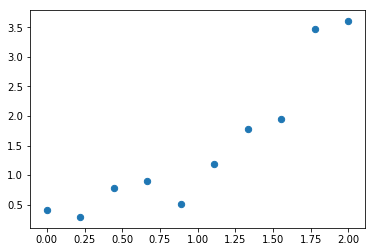

In [36]:
num_training = 10
np.random.seed(666)
X_train = np.linspace(0,2,num_training)
# true function is x^2, adding some noise
true_function = lambda x: x**2
y_train = true_function(X_train) + np.random.normal(0,0.5, size=num_training)
plt.scatter(X_train, y_train, s=40)
plt.show()

## Model
Now we are gonna use a built-in linear regression model (which is a class) `LinearRegression` in `scikit-learn `package to fit not just a linear function but a polynomial function of any degree, e.g. $h(x) = w_{10} x^{10} + w_9 x^9 + \dots + w_1 x + b$, to the data. 

In [20]:
# linear regression
# degree = 1 means use linear polynomial to fit the data
polynomial_features = PolynomialFeatures(degree=2,include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
# pipeline combines both classes

In [7]:
arr = np.arange(10)
arr.shape

(10,)

In [8]:
arr.reshape(-1,1)
arr.shape

(10,)

In [21]:
# pipeline.fit(X_train[:, np.newaxis], y_train) # "training"
pipeline.fit(X_train.reshape(-1,1), y_train)

Pipeline(memory=None,
     steps=[('polynomial_features', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('linear_regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

## Cross-validation (Testing)
Basically we choose a bunch of testing points, see if our model (built from only 10 noisy samples) approximates our true function $x^2$ to a reasonable level.

Using degree 1 polynomial is **underfitting**.

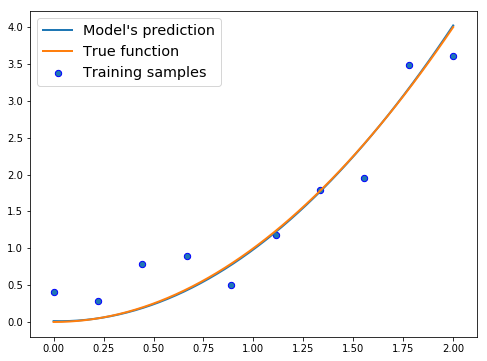

In [37]:
num_samples = 50
X_test = np.linspace(0, 2, num_samples) # this the the testing points
# this is the same with the LinearRegression class's predict method
y_pred = pipeline.predict(X_test.reshape(-1,1)) 
y_true = true_function(X_test)

plt.figure(figsize=(8,6))
plt.plot(X_test, y_pred, linewidth = 2, label="Model's prediction")
plt.plot(X_test, y_true, linewidth = 2, label="True function")
plt.scatter(X_train, y_train, edgecolor='b', s=40, label="Training samples")
plt.legend(loc='best', fontsize = 'x-large')

## In-class exercise: What if we increase the degree?
Try increasing the degree gradually in `PolynomialFeatures()` (since we have packed `PolynomialFeatures()` and `LinearRegression()` into one class, we can use pipeline). 

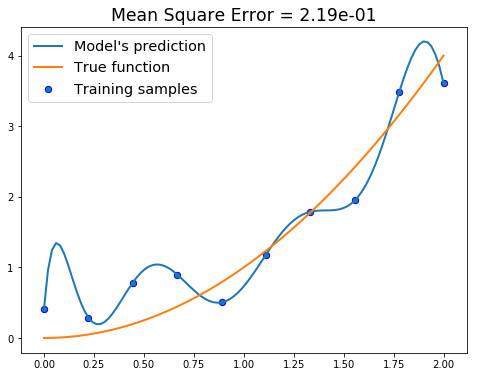

In [15]:
# now we use pipeline to change the polynomial_features directly w/o redefine it
# better than the scikit-learn's example's clumsy usage of pipeline
pipeline.set_params(polynomial_features__degree=9)
pipeline.fit(X_train.reshape(-1,1), y_train)

## Cross-validation
num_samples = 100
X_test = np.linspace(0, 2, num_samples) # this the the testing points
y_pred = pipeline.predict(X_test.reshape(-1,1)) # this the value predicted by the model
y_true = true_function(X_test)
error = np.sum((y_pred - y_true)**2)/num_samples

plt.figure(figsize=(8,6))
plt.plot(X_test, y_pred, linewidth = 2, label="Model's prediction")
plt.plot(X_test, y_true, linewidth = 2, label="True function")
plt.scatter(X_train, y_train, edgecolor='b', s=40, label="Training samples")
plt.legend(loc='best', fontsize = 'x-large')
plt.title("Mean Square Error = {:.2e}".format(error), fontsize = 'xx-large')
plt.show()

## When the degree = 9, it is interpolation. But is it doing us any favor?

### Metric: Mean squared error
Check the mean square error we had at the testing points:
$$
\operatorname {MSE} ={\frac {1}{n_{\text{test}}}}
\sum_{i=1}^{n_{\text{test}}}\left(y^{\text{True}}_{i}- y^{\text{Pred}}_{i} \right)^{2}.
$$

## In-class exercise: Underfitting vs Overfitting
* Underfitting: $k = 1$
* Good fitting: $k = 2,3,4$
* Overfitting: $k \geq 5$

# Multivariate linear regression

Now let us look at the [wine data set on Kaggle](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009) again. The first 11 columns are "objective" measurements, the last column "quality" is a score that is subjectively assigned to the wines. 

In last few lectures, we fit the data $(x_i, y_i)$ using explicit-formula in least-square and gradient descent. There is a similar solution for when you are trying to learn a linear approximation from a given data-set:

$$\{ (x^{(i)}_1,...,x^{(i)}_n,y^{(i)}) \}_{i=1}^N$$

The $i$-th data set has $\mathbf{x}^{(i)} = (x^{(i)}_1,...,x^{(i)}_n)$ as features (totally $n$-features, a.k.a. input values, training data), and $y^{(i)}$ as the label (target values, training label).

We are trying to learn a function to tell the quality of a red wine from all previous 11 columns' inputs

$$h(\mathbf{x}) = h(x_1,....,x_n) = \sum_{i=1}^n w_i x_i + w_0 =  [1, \;\mathbf{x}]^{\top} \mathbf{w}$$

We hope that we have $y^{(i)} \approx h(\mathbf{x}^{(i)})$ for the $i$-th training example. If we succeed in finding a function $h(\mathbf{x})$ like this, and we have seen enough examples of wines and their quality scores, we hope that the function $h(\mathbf{x})$ will also be a good predictor of the wine quality score even when we are given the features for a new wine where the quality score is not known.

Mathematically speaking, starting from a vector of input values $(x^{(j)}_1,...,x^{(j)}_n)$ where $j\neq 1,2,\dots, N$ is not in our training samples, this function should be able to generate an output (target value) $y^{(j)}$ which is a good predictor. For example, given this input $(x^{(j)}_1,...,x^{(j)}_n)$, including the acidities, sulphur concentration, etc (which represents features), we can use our model to predict a $y^{(j)}$ that represents the quality of this wine. 

## Reading: How to achieve this goal?

----

### Loss function:
$$
L(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^N \left( h(\mathbf{x}^{(i)}) - y^{(i)} \right)^2 = 
\frac{1}{N}\sum_{i=1}^N  
\left( [1, \;\mathbf{x}^{(i)}]^{\top} \mathbf{w} - y^{(i)} \right)^2, \tag{$\ast$}
$$
which in the matrix form, can be written as:
$$
L(\mathbf{w}) = \frac{1}{N}\left\| \mathbf{X} \mathbf{w} - \mathbf{y}\right\|^2
= \frac{1}{N}\left\| 
\text{ }
\begin{pmatrix} 
1 & x^{(1)}_1 & \dots & x^{(1)}_n
\\
1 & x^{(2)}_1 & \dots & x^{(2)}_n
\\
1 &  \ddots &  \ddots & \vdots
\\
1 & x^{(N)}_1 & \dots & x^{(N)}_n
\end{pmatrix}
\begin{pmatrix}
w_0 \\ w_1  \\ \vdots \\ w_n
\end{pmatrix}
- \begin{pmatrix}
y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(N)}
\end{pmatrix}
\text{ } 
\right\|^2.
$$
The matrix $\mathbf{X}$ is an $N\times (n+1)$ matrix, where the $i$-th row ($1\leq i \leq N$) corresponds to the $i$-th data point, and each column corresponds to a feature that is associated with a weight $w_k$ ($k=1,\dots, n$) or the bias $w_0$.

----

### Least-square
We want to minimize the "loss". Solve the linear system generated by $\displaystyle \frac{\partial L}{\partial w_i} = 0$ for the weights and bias. After a long computation (we should be able to compute on paper for $n=2$ case), we will have:
$$
\min_{\mathbf{w} \in \mathbb{R}^{n+1}} L(\mathbf{w}) \Longleftrightarrow  \frac{\partial L}{\partial w_m} = 0 \; \text{ for } k= 0,1,\dots n \Longleftrightarrow 
\text{Solve for } \;\mathbf{w} \;\text{ in }\; (\mathbf{X}^{\top} \mathbf{X})\mathbf{w} = \mathbf{X}^\top \mathbf{y}
$$

----

### Gradient descent (Verify this by ourselves)


Taking derivative with respect to the $k$-th weight based on equation $(\ast)$ yields: for $k=0,1,\dots, n$
$$
\frac{\partial L}{\partial w_k} = \frac{2}{N}\sum_{i=1}^N \frac{\partial h}{\partial w_k} \left(h(\mathbf{x}^{(i)}) - y^{(i)}\right)
= \frac{2}{N}\sum_{i=1}^N x^{(i)}_k \left( [1, \;\mathbf{x}^{(i)}]^{\top} \mathbf{w} - y^{(i)}\right),
$$
which is the sum of the product of $k$-th feature and the residual 
$[1, \;\mathbf{x}^{(i)}]^{\top} \mathbf{w} - y^{(i)}$. 

Now if we take the gradient with respect to all features:
$$
\frac{\partial L}{\partial \mathbf{w}} = \frac{2}{N}\sum_{i=1}^N \frac{\partial h}{\partial \mathbf{w}} \left(h(\mathbf{x}^{(i)}) - y^{(i)}\right)
= \frac{2}{N}\sum_{i=1}^N[1, \;\mathbf{x}^{(i)}]^{\top} \left( [1, \;\mathbf{x}^{(i)}]^{\top} \mathbf{w} - y^{(i)}\right),
$$

Copying the routine from Lecture 14 and 16 and adapt it here: $w_{k,m}$ stands for the weight for the $k$-th feature in the $m$-th iteration of the gradient descent.

> Choose initial guess $\mathbf{w}_0 := (w_{0,0}, w_{1,0}, w_{2,0}, \dots, w_{n,0})$ and step size (learning rate) $\eta$<br><br>
>    For $m=0,1,2, \cdots, M$<br><br>
>     &nbsp;&nbsp;&nbsp;&nbsp;   $\mathbf{w}_{m+1} =  \mathbf{w}_m - \eta\,\nabla L\left(\mathbf{w}_m\right) $


## Tool: scikit-learn
Reading: [https://scikit-learn.org/stable/modules/linear_model.html](https://scikit-learn.org/stable/modules/linear_model.html)

In [23]:
# we will use scikit-learn again
# import all columns from winequality-red
wine_data = np.loadtxt('winequality-red.csv', delimiter=',', skiprows=1)

In [26]:
arr1 = np.arange(10).reshape(5,-1)
arr1
np.concatenate((np.ones([5,1]), arr1), axis = 1)

array([[1., 0., 1.],
       [1., 2., 3.],
       [1., 4., 5.],
       [1., 6., 7.],
       [1., 8., 9.]])

In [27]:
# choose train and test data
X_train = wine_data[:-100,:-1] # no last column, last column is the quality score which is y
y_train = wine_data[:-100,-1]
ones = np.ones([len(y_train),1])
X_train = np.concatenate((ones, X_train), axis=1) # concatenating ones to the X_train as the first column


X_test = wine_data[-100:,:-1]
y_test = wine_data[-100:,-1]
ones_test = np.ones([len(y_test),1])
X_test = np.concatenate((ones_test, X_test), axis=1) # concatenating ones to the X_train as the first column

In [32]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
# wine_reg = linear_model.LinearRegression()
wine_reg = LinearRegression()
wine_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [29]:
# Make predictions using the testing set
y_pred = wine_reg.predict(X_test)

### Cross-validation (Judgement day...)

#### Metric 1: Mean squared error
$$
\text{MSE}(\mathbf{y}^{\text{Actual}}, \mathbf{y}^{\text{Pred}}) = \frac{1}{n_\text{test}} 
\sum_{i=1}^{n_\text{test}} (y^{(i),\text{Actual}} - y^{(i),\text{Pred}})^2.
$$

In [30]:
mean_square_error = (1/len(y_test))*np.sum((y_test- y_pred)**2)
print("Mean squared error is: %.5f" % mean_square_error)
# kinda small...kinda big...

Mean squared error is: 0.34062


### Cross-validation (Judgement day...)

#### Metric 2: Coefficient of determination $R^2$
$$
R^2\Big(\mathbf{y}^{\text{Actual}}, \mathbf{y}^{\text{Pred}}\Big) = 1 - \frac{\displaystyle\sum_{i=1}^{n_{\text{test}}} \left(y^{(i),\text{Actual}} - y^{(i),\text{Pred}}\right)^2}{\displaystyle\sum_{i=1}^{n_\text{test}} (y^{(i),\text{Actual}} - \bar{y}^{\text{Actual}})^2}
\quad 
\text{ where }\; \bar{y}^{\text{Actual}} = \displaystyle\frac{1}{n_{\text{test}}} 
\sum_{i=1}^{n_\text{test}} y^{(i),\text{Actual}}
$$
Let us use wikipedia's image to explain this metric
<img src="https://upload.wikimedia.org/wikipedia/commons/8/86/Coefficient_of_Determination.svg" alt="Rsquared" width="600"/>
$$
R^2 = 1-{\frac {\color {blue}{\text{residual sum of squares }} }{\color {red}{\text{total sum of squares}}}}
$$
In regression, the $R^2$ coefficient of determination measures how well the regression predictions approximate the real data points. An $R^2$ of 1 indicates that the regression prediction perfectly fit the test data.

In [31]:
R_squared = 1 - (np.sum((y_test- y_pred)**2))/(np.sum((y_test- y_test.mean())**2))
print("R squared is: %.5f" % R_squared)

R squared is: 0.28002


R squared is less than 0.5, our model is "bad".

### How to improve?
We will see next time.

# Exercise 1
Read the `scikit-learn`'s built-in [training and testing data splitting function](https://scikit-learn.org/0.15/modules/generated/sklearn.cross_validation.train_test_split.html), and use it divide the data into two groups randomly (20% testing, 80% training), repeat the multivariate regression above, do you get similar answers?

In [35]:
from sklearn.model_selection import train_test_split
X = wine_data[:,:-1]
y = wine_data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
wine_reg = LinearRegression()
wine_reg.fit(X_train,y_train)
wine_reg.score(X_test,y_test) # score function is R squared

0.2645204834529137